In [ ]:
import re
import regex
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [ ]:
fileMessages = 'drive/My Drive/log_messages.txt'
fileNames = 'drive/My Drive/common_names.txt'

In [ ]:
common_names = []
with open(fileNames, encoding='UTF-8') as f:
  while True:
    line = f.readline()
    if not line:
      break
    common_names.append(line.split("\n")[0])
common_names[0]

'Michael'

In [ ]:
def stringToNumber(author):
  author = re.sub('[\.\? ]', '', author.lower())
  number = ''
  for letter in author:
    number = number+str(ord(letter) - 96)
  return int(number)

In [ ]:
def isNewMessage(line):
  pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+) ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
  result = re.match(pattern, line)
  return True if result else False

In [ ]:
preData = []
with open(fileMessages, encoding='UTF-8') as f:
  f.readline()
  messageBuffer = []
  date, time, author = None, None, None
  while True:
    line = f.readline()
    if not line:
      break
    if isNewMessage(line) and line.split(' - ')[1].find(':') != -1:
      if len(messageBuffer) > 0:
        preData.append([date, time, author, ''.join(messageBuffer)])
      messageBuffer.clear()

      lineSplit = line.split(' - ')
      date = lineSplit[0].split(' ')[0]
      
      time = lineSplit[0].split(' ')[1]
      
      author = lineSplit[1].split(':')[0]
     
      messageBuffer.append(lineSplit[1].split(': ')[1].split('\n')[0])
    else:
      messageBuffer.append(line)

In [ ]:
df = pd.DataFrame(preData, columns=['Date','Time', 'Author', 'Message'])
#Remove line that is not necessary
df.drop(0,inplace=True) 

In [ ]:
#Saving quantity of members in group
quantity_of_members = len(df.Author.unique())

In [ ]:
#Removing message that midia file
df = df.loc[df.Message != '<Arquivo de mídia oculto>']

#Removing message that contains contact file (.vcf)
df = df[~df.Message.str.contains('.vcf')]

df.reset_index(inplace=True)
df.drop(axis=1,labels='index', inplace=True)

In [ ]:
df.Date = pd.to_datetime(df.Date)

In [ ]:
for index in df.index:

  #If author name is a number, modify to pseudoname
  if re.search('^\+(\d{2}) (\d{2}) (\d{4}|\d{5})\-(\d{4})',df['Author'].iloc[index]):
    pattern = re.compile('^\+(\d{2}) (\d{2}) (\d{4}|\d{5})\-(\d{4})')
    number_author = pattern.sub(r"\1\2\3\4", df['Author'].iloc[index])
    df['Author'].iloc[index] = common_names[int(number_author)%quantity_of_members]
  
  #If author name is a original name, modify to pseudoname
  else:
    df['Author'].iloc[index] = common_names[stringToNumber(df['Author'].iloc[index])%quantity_of_members]
  
  #If message contains quote number, modify to pseudoname
  cited_number = re.search(r'(\d{12}|\d{13})',df['Message'].iloc[index])
  if cited_number:
    df['Message'].iloc[index] = re.sub(r'(\d{12}|\d{13})',common_names[int(cited_number.group(0))%quantity_of_members], df['Message'].iloc[index])
    

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df.Author.unique()

array(['Alicia', 'Sean', 'Joshua', 'Elizabeth', 'Lisa', 'Andrew',
       'Brandon', 'Heather', 'Katie', 'Mary', 'Kenneth', 'Stephen',
       'Aaron', 'Thomas', 'Timothy', 'Crystal', 'Alexander', 'Nicholas',
       'Sara', 'Jamie', 'Michelle', 'Christine', 'Stephanie', 'Cody',
       'Zachary', 'Anthony', 'Lauren', 'Joseph', 'Mark', 'Nathan',
       'Tiffany', 'Danielle', 'Eric', 'Andrea', 'Amanda', 'Kelly',
       'Brittany', 'Kyle', 'William', 'Amy', 'Vanessa', 'Ashley', 'Amber',
       'Nicole', 'Benjamin', 'Lindsay', 'Courtney', 'Ryan', 'Kristen',
       'Justin', 'Kevin', 'Katherine', 'Michael', 'Travis', 'David',
       'Jonathan', 'Jessica', 'Paul', 'Lindsey', 'Scott', 'Jennifer'],
      dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12168 entries, 0 to 12167
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     12168 non-null  datetime64[ns]
 1   Time     12168 non-null  object        
 2   Author   12168 non-null  object        
 3   Message  12168 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 380.4+ KB


In [ ]:
data = df[['Author','Message']].groupby(['Author'])

In [ ]:
data = data.count()

In [ ]:
data.sort_values(by='Message', ascending=False)

,Message
Author,
Jamie,1970
Heather,804
Anthony,796
Alexander,789
Crystal,728
...,...
Michael,2
Tiffany,2
Jennifer,2


## Who speak more?

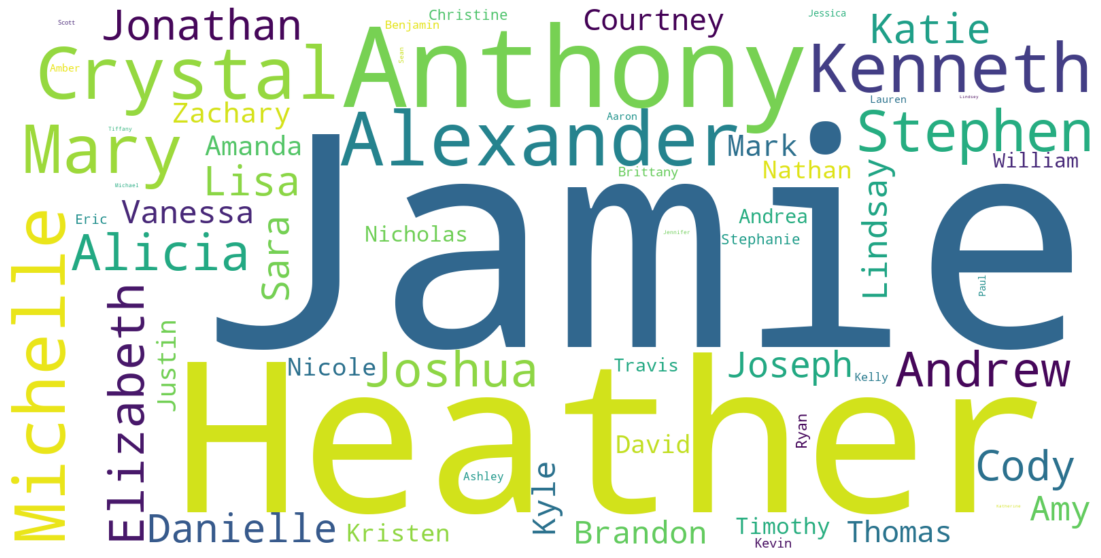

In [ ]:
wordcloud = WordCloud(width=1600, height=800, background_color='white', collocations=False)
text = ' '.join(author for author in df['Author'])
wordcloud.generate(text)

plt.figure( figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## What are the key words more mention?

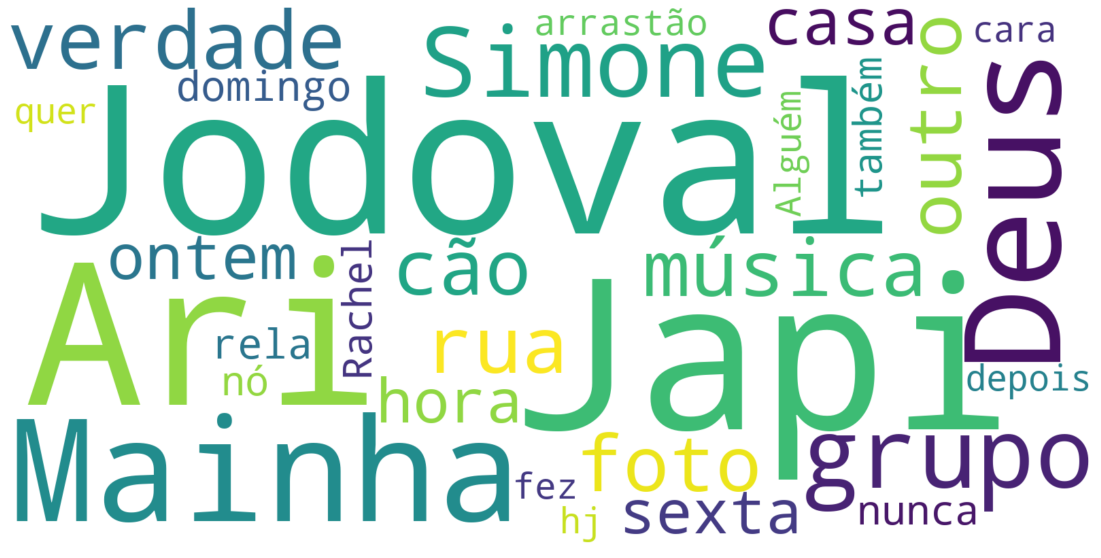

In [ ]:
text = ' '.join(message for message in df.Message)
stopwords = set(STOPWORDS)
stopwords.update(['não', 'da', 'ele', 'ela', 'já', 'que', 'de', 'em', 'só', 'pra', 'eu', 'na', 'tá', 'tem', 'nos', 'se', 'foi', 'uma', 'isso','vai', 'dia', 'por', 
                  'os', 'mai', 'gente', 'Quem', 'nem', 'ser','hoje', 'vou','esse', 'mais', 'um', 'aqui', 'povo', 'Vamo', 'essa', 'kkk', 'né', 'Bom', 'bem', 'tu', 
                  'Kkkk', 'todo', 'viu', 'Vamos', 'Tô', 'nada', 'lá','era','Deu','Quero','agora', 'meu','eles','mesmo','aí', 'fazer','mesmo','sim','você','Kkkkk', 
                  'ta','Kkkkkk', 'Poi', 'ai', 'Mas', 'pq', 'até', 'ainda', 'num', 'tbm','vc','para','dele', 'Pois', 'muito', 'ter', 'todos', 'Cuida', 'pode','tudo',
                  'ver', 'como', 'vão', 'como', 'amanhã','disse', 'minha', 'mulher', 'Bora', 'sabe', 'São', 'quando','tava','toda', 'coisa', 'ninguém', 'sei', 'Kkkkkkk',
                  'demais', 'ou', 'pelo', 'kk', 'ja', 'nosso', 'fica','tarde', 'Queria', 'assim', 'Acho', 'vem','sem', 'faz', 'msm', 'tão', 'tenho', 'vcs', 'adicionou','ir',
                  'está', 'ficar', 'logo', 'está', 'onde', 'pro', 'será', 'dos', 'tinha', 'boa', 'ia', 'falar', 'dela', 'dizer'])
wordcloud = WordCloud(width=1600, height=800, background_color='white', collocations=False, stopwords=stopwords, max_words=30)
wordcloud.generate(text)

plt.figure( figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Text(0, 0.5, 'Time')

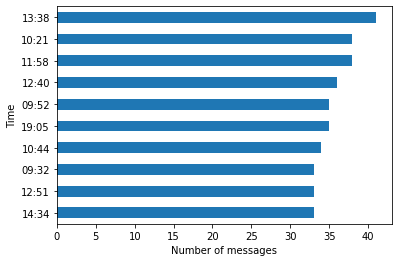

In [ ]:
df['Time'].value_counts().head(10).sort_values(ascending=True).plot.barh()
plt.xlabel('Number of messages')
plt.ylabel('Time')

Text(0, 0.5, 'Date')

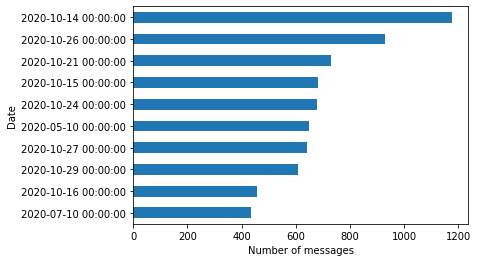

In [ ]:
df['Date'].value_counts().head(10).sort_values(ascending=True).plot.barh()
plt.xlabel('Number of messages')
plt.ylabel('Date')